In [ ]:
# Import the necessary libraries
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [ ]:
print("The number of images with facemask labelled 'yes':",len(os.listdir('/content/drive/MyDrive/observations-master/experiements/data/with_mask')))
print("The number of images with facemask labelled 'no':",len(os.listdir('/content/drive/MyDrive/observations-master/experiements/data/without_mask')))

The number of images with facemask labelled 'yes': 690
The number of images with facemask labelled 'no': 686


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def data_summary(main_path):
    
    yes_path = '/content/drive/MyDrive/observations-master/experiements/data/with_mask'
    no_path = '/content/drive/MyDrive/observations-master/experiements/data/without_mask'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 
    
augmented_data_path = 'facemask-dataset/trial1/augmented data1/'    
data_summary(augmented_data_path)

Number of examples: 1376
Percentage of positive examples: 50.145348837209305%, number of pos examples: 690
Percentage of negative examples: 49.854651162790695%, number of neg examples: 686


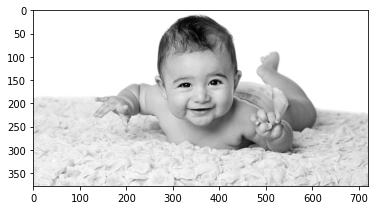

In [ ]:
#  Loading the image to be tested
test_image = cv2.imread('/content/drive/MyDrive/BABY-23.jpg')

# Converting to grayscale as opencv expects detector takes in input gray scale images
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Displaying grayscale image
plt.imshow(test_image_gray, cmap='gray')

Since we know that OpenCV loads an image in BGR format so we need to convert it into RBG format to be able to display its true colours. Let us write a small function for that.

In [ ]:
def convertToRGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Haar cascade files

OpenCV comes with a lot of pre-trained classsifiers. For instance there are classifiers for smile, eyes,face etc. These come in the form of xml files and are located in `opencv/data/haarcascades/` folder. However, just to make things simple, you can also access them from here.Download the xml fiels and place them in data folder in the same working directory as the jupyter notebook.

### Loading the classifier for frontal face

In [ ]:
haar_cascade_face = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_default.xml')


In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

img = cv2.imread('/content/drive/MyDrive/BABY-23.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# Face detection

We shall be using the detectMultiscale module of the classifier.This function will return the co-ordinates(x and y posiiton plus the height and width) of the detected faces as Rect(x,y,w,h). 

In [ ]:
faces_rects = haar_cascade_face.detectMultiScale(test_image_gray, scaleFactor = 1.2, minNeighbors = 5);

# Let us print the no. of faces found
print('Faces found: ', len(faces_rects))

Faces found:  1


Our next step is to loop over all the co-ordinates it returned and draw rectangles around them using Open CV.We will be drawing a green rectangle with thicknessof 2

In [ ]:
for (x,y,w,h) in faces_rects:
     cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        

Finally, we shall display the original image in coloured to see if the face has been detected correctly or not.

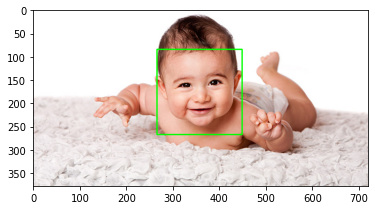

In [ ]:
#convert image to RGB and show image
plt.imshow(convertToRGB(test_image))

### Let us create a generalised function for the entire face detection process.

In [ ]:
def detect_faces(cascade, test_image, scaleFactor = 1.1):
    # create a copy of the image to prevent any changes to the original one.
    image_copy = test_image.copy()
    
    #convert the test image to gray scale as opencv face detector expects gray images
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    
    # Applying the haar classifier to detect faces
    faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
    
    for (x, y, w, h) in faces_rect:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 15)
        
    return image_copy

### Testing the function on new image




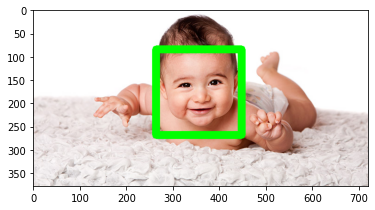

In [ ]:
#loading image
test_image2 = cv2.imread('/content/drive/MyDrive/BABY-23.jpg')

#call the function to detect faces
faces = detect_faces(haar_cascade_face, test_image2)

#convert to RGB and display image
plt.imshow(convertToRGB(faces))


### Saving the Image

In [ ]:
 cv2.imwrite('image1.png',faces)

True

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE+'/'+ unitData
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = SOURCE +'/'+ unitData
        final_train_set = TRAINING+'/' + unitData
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = SOURCE +'/'+ unitData
        final_test_set = TESTING + '/'+unitData
        copyfile(temp_test_set, final_test_set)
        
        
YES_SOURCE_DIR = "/content/drive/MyDrive/observations-master/experiements/data/with_mask"
TRAINING_YES_DIR = "/content/drive/MyDrive/observations-master/experiements/dest_folder/train/with_mask"
TESTING_YES_DIR = "/content/drive/MyDrive/observations-master/experiements/dest_folder/test/with_mask"
NO_SOURCE_DIR = "/content/drive/MyDrive/observations-master/experiements/data/without_mask"
TRAINING_NO_DIR = "/content/drive/MyDrive/observations-master/experiements/dest_folder/train/without_mask"
TESTING_NO_DIR = "/content/drive/MyDrive/observations-master/experiements/dest_folder/test/without_mask"
split_size = .8
split_data(YES_SOURCE_DIR, TRAINING_YES_DIR, TESTING_YES_DIR, split_size)
split_data(NO_SOURCE_DIR, TRAINING_NO_DIR, TESTING_NO_DIR, split_size)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
TRAINING_DIR = "/content/drive/MyDrive/observations-master/experiements/dest_folder/train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "/content/drive/MyDrive/observations-master/experiements/dest_folder/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 1467 images belonging to 2 classes.
Found 429 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
147/147 [==============================] - 185s 1s/step - loss: 0.4337 - acc: 0.8098 - val_loss: 0.2907 - val_acc: 0.8671
INFO:tensorflow:Assets written to: model-001.model/assets
Epoch 2/30
147/147 [==============================] - 166s 1s/step - loss: 0.2758 - acc: 0.8950 - val_loss: 0.0997 - val_acc: 0.9674
INFO:tensorflow:Assets written to: model-002.model/assets
Epoch 3/30
147/147 [==============================] - 164s 1s/step - loss: 0.2537 - acc: 0.9025 - val_loss: 0.0710 - val_acc: 0.9837
INFO:tensorflow:Assets written to: model-003.model/assets
Epoch 4/30
147/147 [==============================] - 163s 1s/step - loss: 0.2175 - acc: 0.9202 - val_loss: 0.2721 - val_acc: 0.8858
Epoch 5/30
147/147 [==============================] - 163s 1s/step - loss: 0.2018 - acc: 0.9209 - val_loss: 0.0794 - val_acc: 0.9697
Epoch 6/30
147/147 [==============================] - 161s 1s/step - loss: 0.1822 - acc: 0.9346 - val_loss: 0.0534 - val_acc: 0.9883
INFO:tensorflow:Assets writt

In [ ]:
face_clsfr=cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_default.xml')

In [ ]:
labels_dict={1:'without_mask',0:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
from google.colab.patches import cv2_imshow
# We load the xml file
classifier = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_default.xml')

im=cv2.imread('/content/drive/MyDrive/observations-master/experiements/dest_folder/train/without_mask/10.jpg')
# Resize the image to speed up detection
im=cv2.flip(im,1,1) #Flip to act as a mirror

  # Resize the image to speed up detection
mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))
# detect MultiScale / faces 
faces = classifier.detectMultiScale(mini)
result=0
# Draw rectangles around each face
for f in faces:
    (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
    #Save just the rectangle faces in SubRecFaces
    face_img = im[y:y+h, x:x+w]
    resized=cv2.resize(face_img,(150,150))
    normalized=resized/255.0
    reshaped=np.reshape(normalized,(1,150,150,3))
    reshaped = np.vstack([reshaped])
    result=model.predict(reshaped)
    print(result)
    
    label=np.argmax(result,axis=1)[0]
  
    cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
    cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
    cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    
# Show the image
cv2_imshow(im)
